# Lab 17: VEGAS Tutorial

In this lab, we will learn how to use the VEGAS algorithm to estimate the integral of a function. VEGAS is a Monte Carlo algorithm that uses importance sampling to estimate the integral of a function. The algorithm is particularly useful for high-dimensional integrals, where traditional methods such as the trapezoidal rule or Simpson's rule become impractical.

We will attempt to produce 100,000 events of the following function composed of two Gaussian distributions:

$$f(x, y) = A_1 \exp\left [-\frac{1}{2} \left ( \frac{(x - \mu_{1x})^2}{\sigma_{1x}^2} + \frac{(y - \mu_{1y})^2}{\sigma_{1y}^2} \right ) \right] + A_2 \exp\left [-\frac{1}{2} \left ( \frac{(x - \mu_{2x})^2}{\sigma_{2x}^2} + \frac{(y - \mu_{2y})^2}{\sigma_{2y}^2} \right ) \right]$$

over the range $0 < x, y < 5$. We will use the following parameters for the function:
$$A_1 = 1.0, \quad\mu_{1x} = 2.5, \quad\sigma_{1x} = 1.0, \quad\mu_{1y} = 2.5, \quad\sigma_{1y} = 1.0$$
$$A_2 = 4.0, \quad\mu_{2x} = 2.5, \quad\sigma_{2x} = 0.1, \quad\mu_{2y} = 2.5, \quad\sigma_{2y} = 0.1$$

In [13]:
# import the required libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [15]:
A1 = 1.0
A2 = 4.0
MU1X = 2.5
MU2X = 2.5
SIGMA1X = 1.0
SIGMA2X = 0.1
MU1Y = 2.5
MU2Y = 2.5
SIGMA1Y = 1.0
SIGMA2Y = 0.1

XMIN = 0.0
YMIN = 0.0
XMAX = 5.0
YMAX = 5.0


def f(yy1, yy2):
    exponent1 = -0.5 * (
        ((yy1 - MU1X) ** 2) / (2 * SIGMA1X**2)
        + ((yy2 - MU1Y) ** 2) / (2 * SIGMA1Y**2)
    )
    exponent2 = -0.5 * (
        ((yy1 - MU2X) ** 2) / (2 * SIGMA2X**2)
        + ((yy2 - MU2Y) ** 2) / (2 * SIGMA2Y**2)
    )
    result = A1 * np.exp(exponent1) + A2 * np.exp(exponent2)
    return result


F_VAL_MAX = f(MU1X, MU1Y)

This lego plot will show the function we are trying to integrate.

In [19]:
def lego_plot(xAmplitudes, yAmplitudes, nBins, xLabel, yLabel, title):
    x = np.array(xAmplitudes)  # turn x,y data into numpy arrays
    y = np.array(yAmplitudes)  # useful for regular matplotlib arrays

    fig = plt.figure()  # create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection="3d")

    # make histograms - set bins
    hist, xedges, yedges = np.histogram2d(x, y, bins=(nBins, nBins))
    xpos, ypos = np.meshgrid(xedges[:-1] + xedges[1:], yedges[:-1] + yedges[1:])

    xpos = xpos.flatten() / 2.0
    ypos = ypos.flatten() / 2.0
    zpos = np.zeros_like(xpos)

    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = hist.flatten()

    cmap = mpl.colormaps["jet"]
    max_height = np.max(dz)  # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k - min_height) / max_height) for k in dz]

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort="average")
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.xlim(XMIN, XMAX)
    plt.ylim(YMIN, YMAX)
    plt.show()

## Acceptance-rejection Method
Now, we define the standard acceptance-rejection method.

In [17]:
def brute_force(nPoints, seed=None):
    nFunctionEval = 0
    yy1_rej_method = []
    yy2_rej_method = []
    maxWeightEncounteredRej = -1.0e20
    generator = np.random.RandomState(seed=seed)
    while len(yy1_rej_method) < nPoints:
        rr = generator.uniform(size=3)
        yy1, yy2 = XMIN + rr[0] * (XMAX - XMIN), YMIN + rr[1] * (YMAX - YMIN)
        nFunctionEval += 1
        f_val = f(yy1, yy2)
        if f_val > maxWeightEncounteredRej:
            maxWeightEncounteredRej = f_val
        if f_val > F_VAL_MAX:
            print(
                f" f_val={f_val} exceeds F_VAL_MAX={F_VAL_MAX}, program will now exit"
            )
            exit(99)
        if f_val / F_VAL_MAX > rr[2]:
            yy1_rej_method.append(yy1)
            yy2_rej_method.append(yy2)
    return {
        "yy1": yy1_rej_method,
        "yy2": yy2_rej_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncounteredRej,
    }

## Vegas Method

In [32]:
def setup_intervals(NN=100, KK=2000, nIterations=4000, alpha_damp=1.5, seed=None):
    """
    Input:
        NN: Number of intervals in [XMIN, XMAX] or [YMIN, YMAX]
        KK: function evaluations per iteration
        nIterations: number of iterations
        alpha_damp: damping parameter in the Vegas algorithm
    Return:
        Intervals specified by xLow, yLow: each is a 1D numpy array of size NN+1, with
        xLow[0] = 0, xLow[NN] = ym; yLow[0] = 0, yLow[NN] = ym
    """

    # intitial intervals: uniform intervals between XMIN/YMIN and XMAX/YMAX
    xLow = XMIN + (XMAX - XMIN) / NN * np.arange(NN + 1)
    delx = np.ones(NN) * (XMAX - XMIN) / NN
    px = np.ones(NN) / (XMAX - XMIN)  # probability density in each interval
    yLow = YMIN + YMAX / NN * np.arange(NN + 1)
    dely = np.ones(NN) * (YMAX - YMIN) / NN
    py = np.ones(NN) / (YMAX - YMIN)

    generator = np.random.RandomState(seed=seed)
    for _ in range(nIterations):
        ixLow = generator.randint(0, NN, size=KK)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform(size=KK)
        iyLow = generator.randint(0, NN, size=KK)
        yy = yLow[iyLow] + dely[iyLow] * generator.uniform(size=KK)
        ff = f(xx, yy)
        f2barx = np.array(
            [sum((ff[ixLow == i] / py[iyLow[ixLow == i]]) ** 2) for i in range(NN)]
        )
        fbarx = np.sqrt(f2barx)
        f2bary = np.array(
            [sum((ff[iyLow == i] / px[ixLow[iyLow == i]]) ** 2) for i in range(NN)]
        )
        fbary = np.sqrt(f2bary)
        fbardelxSum = np.sum(fbarx * delx)
        fbardelySum = np.sum(fbary * dely)
        logArgx = fbarx * delx / fbardelxSum
        logArgy = fbary * dely / fbardelySum
        mmx = KK * pow((logArgx - 1) / np.log(logArgx), alpha_damp)
        mmx = mmx.astype(int)
        mmx = np.where(mmx > 1, mmx, 1)
        mmy = KK * pow((logArgy - 1) / np.log(logArgy), alpha_damp)
        mmy = mmy.astype(int)
        mmy = np.where(mmy > 1, mmy, 1)
        xLowNew = [xLow[i] + np.arange(mmx[i]) * delx[i] / mmx[i] for i in range(NN)]
        xLowNew = np.concatenate(xLowNew, axis=0)
        yLowNew = [yLow[i] + np.arange(mmy[i]) * dely[i] / mmy[i] for i in range(NN)]
        yLowNew = np.concatenate(yLowNew, axis=0)
        nCombx = int(len(xLowNew) / NN)
        nComby = int(len(yLowNew) / NN)
        i = np.arange(NN)
        xLow[:-1] = xLowNew[i * nCombx]
        yLow[:-1] = yLowNew[i * nComby]
        delx = np.diff(xLow)
        dely = np.diff(yLow)
        px = 1.0 / delx / NN
        py = 1.0 / dely / NN

    return xLow, yLow, delx, dely


def vegas(
    nPoints,
    vegasRatioFactor,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=None,
):
    xLow, yLow, delx, dely = setup_intervals(NN, KK, nIterations, alpha_damp, seed)
    vegasRatioMax = vegasRatioFactor * F_VAL_MAX * NN * NN * delx[NN - 2] * dely[NN - 2]
    nFunctionEval = 0
    yy1_vegas_method = []
    yy2_vegas_method = []
    yy1_vrho_method = []
    yy2_vrho_method = []
    maxWeightEncountered = -1.0e20

    generator = np.random.RandomState(seed=seed)
    while len(yy1_vegas_method) < nPoints:
        ixLow = generator.randint(0, NN)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform()
        iyLow = generator.randint(0, NN)
        yy = yLow[iyLow] + delx[iyLow] * generator.uniform()
        yy1_vrho_method.append(xx)
        yy2_vrho_method.append(yy)
        nFunctionEval += 1
        f_val = f(xx, yy)
        ratio = f_val * NN * NN * delx[ixLow] * dely[iyLow]
        if ratio > maxWeightEncountered:
            maxWeightEncountered = ratio
        if ratio > vegasRatioMax:
            print(
                f"ratio={ratio} exceeds vegasRatioMax={vegasRatioMax}, yy={yy} program will now exit "
            )
            exit(99)
        if ratio / vegasRatioMax > generator.uniform():
            yy1_vegas_method.append(xx)
            yy2_vegas_method.append(yy)

    return {
        "yy1vrho": yy1_vrho_method,
        "yy2vrho": yy2_vrho_method,
        "yy1vegas": yy1_vegas_method,
        "yy2vegas": yy2_vegas_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncountered,
        "vegasRatioMax": vegasRatioMax,
    }

Run both algorithms and compare results

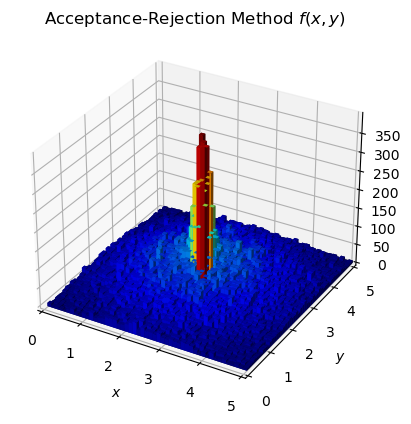

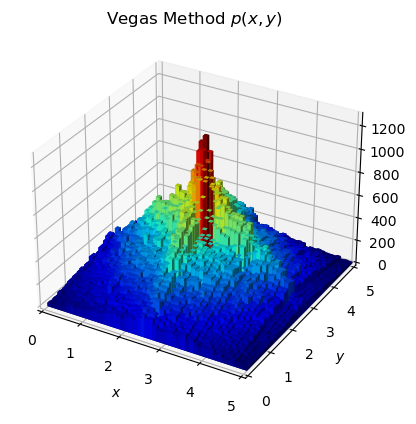

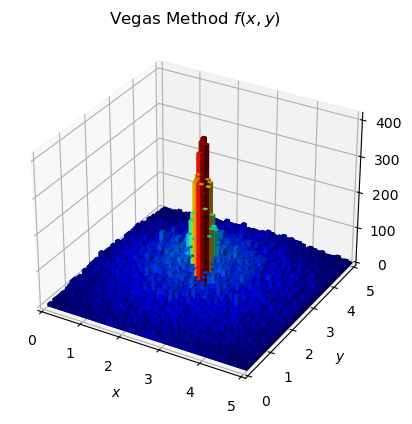

Acceptance-rejection method nPoints=100000, nFunctionEval=1114972, maxWeightEncounteredRej=4.997967721213925, F_VAL_MAX=5.0
Vegas method nPoints=100000, nFunctionEval=643186, maxWeightEncountered=55.102757001135664, vegasRatioMax=72.56332099525926, vegasRatioFactor=0.1


In [33]:
def plot_results(
    nPoints,
    vegasRatioFactor,
    nBins=50,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=None,
):
    bf = brute_force(nPoints, seed)
    vg = vegas(nPoints, vegasRatioFactor, NN, KK, nIterations, alpha_damp, seed)
    # brute force
    titleRej = r"Acceptance-rejection Method $f(x,y)$"
    lego_plot(bf["yy1"], bf["yy2"], nBins, "$x$", "$y$", titleRej)
    plt.show()

    # Vegas method
    titleVrho = r"Vegas Method $p(x,y)$"
    lego_plot(vg["yy1vrho"], vg["yy2vrho"], nBins, "$x$", "$y$", titleVrho)
    plt.show()

    titleVegas = r"Vegas Method $f(x,y)$"
    lego_plot(vg["yy1vegas"], vg["yy2vegas"], nBins, "$x$", "$y$", titleVegas)
    plt.show()

    print(
        f"Acceptance-rejection method nPoints={nPoints}, nFunctionEval={bf['nFunEval']}, maxWeightEncounteredRej={bf['maxWeightEncountered']}, F_VAL_MAX={F_VAL_MAX}"
    )
    print(
        f"Vegas method nPoints={nPoints}, nFunctionEval={vg['nFunEval']}, maxWeightEncountered={vg['maxWeightEncountered']}, vegasRatioMax={vg['vegasRatioMax']}, vegasRatioFactor={vegasRatioFactor}"
    )


plot_results(100_000, 0.1)

## Exercises
1. Try without the `alpha_damp` parameter, i.e.
```python
# mmx = KK * pow((logArgx - 1) / np.log(logArgx), alpha_damp)
mmx = KK * logArgx
mmx = mmx.astype(int)
mmx = np.where(mmx > 1, mmx, 1)
# mmy = KK * pow((logArgy - 1) / np.log(logArgy), alpha_damp)
mmy = KK * logArgy
mmy = mmy.astype(int)
mmy = np.where(mmy > 1, mmy, 1)
```
2. Change the form of the Gaussians to be offset from one another, e.g.
```python
A1 = 1.0
A2 = 1.0
MU1X = 2.5
MU2X = 2.5
SIGMA1X = 1.0
SIGMA2X = 1.0
MU1Y = -2.5
MU2Y = -2.5
SIGMA1Y = 1.0
SIGMA2Y = 1.0

XMIN = -5.0
YMIN = -5.0
XMAX = 5.0
YMAX = 5.0
```
Note, you may have to change `vegasRatioFactor` to a different value.